In [1]:
from fastai.vision.all import *

In [2]:
mimic_path = Path("/home/code-base/scratch_space/extra/physionet.org/files/mimic-cxr-jpg/2.0.0/")

In [3]:
Path.ls_names = lambda o: o.ls().map(lambda o: o.name)

In [4]:
mimic_path.ls_names()

(#9) ['SHA256SUMS.txt','mimic-cxr-2.0.0-split.csv.gz','mimic-cxr-2.0.0-metadata.csv.gz','README','index.html','mimic-cxr-2.0.0-negbio.csv.gz','files','LICENSE.txt','mimic-cxr-2.0.0-chexpert.csv.gz']

In [5]:
(mimic_path/"files").ls_names()

(#11) ['p18','p10','p12','p16','p17','index.html','p19','p15','p13','p11'...]

In [6]:
image_dirs = [o for o in (mimic_path/'files').ls() if o.name.startswith("p") and o.is_dir()]

The dataset contains 377,110 JPG format images and structured labels derived from the 227,827 free-text radiology reports associated with these images. 

#### Images

In [7]:
all_image_files = get_image_files(mimic_path/'files')
len(all_image_files)

377110

In [199]:
def get_image_file_parts(fn): return fn.parent.parent.parent.name, fn.parent.parent.name, fn.parent.name, "/".join(str(fn).split("/")[-4:])

In [204]:
res = parallel(get_image_file_parts, all_image_files, progress=True)

In [205]:
df = pd.DataFrame(res, columns=['Folder', 'PatientID', 'StudyID', 'filename'])

In [206]:
df

,Folder,PatientID,StudyID,filename
0,p18,p18635245,s57591038,p18/p18635245/s57591038/485014fa-f44727de-24b13f26-d2e9a979-086e5167.jpg
1,p18,p18635245,s57591038,p18/p18635245/s57591038/dc407ff9-10bc70a2-a442c521-db54ef56-4b238127.jpg
2,p18,p18562317,s51459612,p18/p18562317/s51459612/381cf034-75ce05c8-c29df027-9cc72659-9a92ddc5.jpg
3,p18,p18562317,s50002358,p18/p18562317/s50002358/0a671e62-7ce9430f-85fcb721-c7c61ba1-6692fc01.jpg
4,p18,p18562317,s50002358,p18/p18562317/s50002358/e686b4cc-9332850f-b76e3ab2-ccb21de0-e7efed0b.jpg
...,...,...,...,...
377105,p14,p14054139,s58294009,p14/p14054139/s58294009/09ded102-001a43d1-0f7c3bb5-ce359d2e-918428d8.jpg
377106,p14,p14054139,s58294009,p14/p14054139/s58294009/30eaf884-ad0f8c23-50af735e-8a333eb0-9bde5126.jpg
377107,p14,p14384560,s54271102,p14/p14384560/s54271102/07d698c8-1e1842d8-b19c94bf-bdf005f6-fd611fc2.jpg
377108,p14,p14384560,s54271102,p14/p14384560/s54271102/e13ce043-87bb7199-893fc6ae-8eb2c729-2a963722.jpg


In [207]:
df.to_parquet("/home/code-base/scratch_space/extra/image_filenames.pqt")

In [24]:
patient_df = df.query(f"PatientID == 'p18635245'"); patient_df

,PatientID,StudyID,filename
0,p18635245,s57591038,p18/p18635245/s57591038/485014fa-f44727de-24b13f26-d2e9a979-086e5167.jpg
1,p18635245,s57591038,p18/p18635245/s57591038/dc407ff9-10bc70a2-a442c521-db54ef56-4b238127.jpg


In [25]:
imgs = [PILImage.create(mimic_path/f'files/{o}') for o in patient_df['filename']]

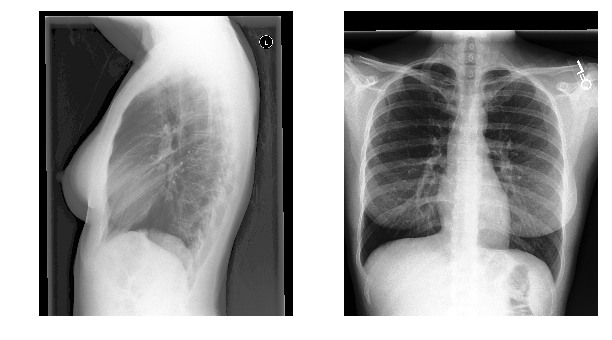

In [27]:
show_images(imgs, nrows=1, ncols=len(imgs), figsize=(10,len(imgs)*10))

#### Text Reports 

The dataset contains 377,110 images corresponding to 227,835 radiographic studies performed at the Beth Israel Deaconess Medical Center in Boston, MA.

In [28]:
cxr_reports_path = Path("/home/code-base/scratch_space/extra/mimic-cxr-reports/")

In [29]:
cxr_reports = get_text_files(cxr_reports_path)
len(cxr_reports)

227835

In [30]:
report = open(np.random.choice(cxr_reports)).read()
print(report)

                                 FINAL REPORT
 HISTORY:  Acute desaturation.
 
 FINDINGS:  In comparison with the study of ___, there are bilateral diffuse
 pulmonary opacifications superimposed upon the previous nodular pulmonary
 opacifications.  This suggests a developing consolidation.  Endotracheal tube
 lies only about 1.2 cm above the carina and should be pulled back several cm. 
 Nasogastric tube extends into the stomach.



#### Data Preprocessing 

**Images**

- Resize all jpeg files to 256 on the larger size

**Text**

- Tokenize all reports with english tokenizer from [CoreNLP](https://stanfordnlp.github.io/CoreNLP/)
- Keep only **Findings** and **Impression** section
- Remove image-text pair samples where number of tokens < 3
- Should have 217k image-text pairs

#### Pretraining ([MIMIC-CXR-II](https://physionet.org/content/mimic-cxr-jpg/2.0.0/))

- **Image Encoder:** ResNet-50
- **Text Encoder:** [ClinicalBERT](https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT). During contrastive training first 6 layers were frozen and only last 6 layers were trained.
    - https://allenai.github.io/scispacy/
- **Image Data Augmentations:** Random resized crop (0.6,1), hflip, affine tfms: rotation -+20 deg, horizontal-vertical translation 0.1, scaling (0.95,1.05), color jittering brightness and contrast from (0.6, 1.4) and gaussian blue (0.1,3), image size = 224
- **Text Data Augmentations:** Radomly sample a sentence from input document (probably after preprocessing).
- Hyperparameters; embed dim=512, tem=0.1 and loss weight=0.75 for pretraining selected by linear evaluation on RSNA image classification task with pretrained ResNet-50 weights.
- 5k validation during pretraining.
- bs = 32.

#### Downstream Tasks

- [RSNA](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview) - used as a binary classification task
- [Chexpert](https://stanfordmlgroup.github.io/competitions/chexpert/) - used expert labelled dataset as test set and a random 5,000 samples as validation 218414/5000/234 - only 234 samples in test
- [COVID-X](https://github.com/lindawangg/COVID-Net) - latest version
- [COVID-19 Radiography Database Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)

#### Ablation Ideas

- With/Without MLP during pretraining
- Use full text during pretraining
- Learnable temperature
- Linear evaluation or knn, which one is better and faster?

### Text Preprocessing

In [31]:
import scispacy
import spacy
nlp = spacy.load("en_core_sci_md")

In [137]:
# !pip install transformers

In [ ]:
# https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT
# https://allenai.github.io/scispacy/

In [145]:
# !pip install scispacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_md-0.4.0.tar.gz

In [112]:
# !pip install ftfy regex
# !pip install pyarrow

In [110]:
def extract_report_sections(report):
    "Extract report section-text pairs that start with SOME_SECTION_TITLE: "
    start_end_idxs = [m.span() for m in re.finditer('[ A-Z]+:', report)]    
    section_texts = []
    for i in range(len(start_end_idxs)): 

        cur_s,cur_e                             = start_end_idxs[i]
        if i == (len(start_end_idxs)-1): next_s = len(report)
        else:                            next_s = start_end_idxs[i+1][0]

        section_name = report[cur_s:cur_e-1].strip()
        section_text = report[cur_e:next_s]
        section_texts.append((section_name, section_text))
    return section_texts

In [111]:
import ftfy,html

def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()

def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

def simple_text_clean(text, do_lower_case=False): 
    text = whitespace_clean(basic_clean(text))
    if do_lower_case: return text.lower()
    else:             return text

In [116]:
report = open(np.random.choice(cxr_reports)).read()
print(report)

 WET READ: ___ ___ ___ 8:00 AM
  
  
  Small bilateral pleural effusions.  Lung fields are clear.  Cardiomediastinal
  silhouette is unremarkable.  No pneumothorax.
 WET READ VERSION #1 ___ ___ ___ 9:29 PM
  Small bilateral pleural effusions.  Lung fields are clear.  Cardiomediastinal
  silhouette is unremarkable.  No pneumothorax.
 ______________________________________________________________________________
                                 FINAL REPORT
 EXAMINATION:  CHEST (PA AND LAT)
 
 INDICATION:  ___ year old woman with cough, SOB. She is s/p C/S. Hx of
 pneumonia in pregnancy  // r/o penumonia
 
 TECHNIQUE:  Chest PA and lateral
 
 COMPARISON:  None.
 
 FINDINGS: 
 
 Heart size is normal.  The mediastinal and hilar contours are normal. The
 pulmonary vasculature is normal. Lungs are clear.  Bilateral small pleural
 effusions are present,. There are no acute osseous abnormalities.  A small
 amount of free air under the right hemidiaphragm is likely related to the
 recent C-sect

In [126]:
def preprocess_report(report_filename):
    "Returns section:text dictionary"
    with open(report_filename) as f:
        report = f.read()
        section_texts = extract_report_sections(report)
        return dict([(tup[0],simple_text_clean(tup[1])) for tup in section_texts])

In [134]:
report_dicts = parallel(preprocess_report, cxr_reports, progress=True)

In [135]:
len(report_dicts)

227835

In [136]:
reports_df = pd.DataFrame(report_dicts)

In [139]:
nona_cols = (~reports_df.isna()).sum()

In [144]:
sorted_cols_counts = nona_cols.sort_values(ascending=False)

In [168]:
q90 = np.quantile(sorted_cols_counts, 0.9)
sorted_cols_counts[sorted_cols_counts>q90]

IMPRESSION                                   187708
COMPARISON                                   154590
INDICATION                                   153658
FINDINGS                                     149760
EXAMINATION                                   94048
TECHNIQUE                                     81374
HISTORY                                       45602
WET READ                                      17556
COMPARISONS                                    8680
CLINICAL HISTORY                               7118
REASON FOR EXAMINATION                         5839
NOTIFICATION                                   5753
REASON FOR EXAM                                4427
CLINICAL INFORMATION                           4023
EXAM                                           3906
STUDY                                          2787
CLINICAL INDICATION                            1943
CONCLUSION                                     1803
TWO VIEWS                                      1737
TYPE OF EXAM

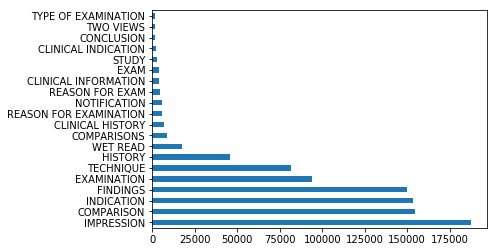

In [156]:
sorted_cols_counts.head(20).plot(kind='barh');

In [180]:
def get_dir_patient_study(report_fn):
    "folder, patient id, study id"
    return report_fn.parent.parent.name, report_fn.parent.name, report_fn.stem

In [181]:
patient_ids = parallel(get_dir_patient_study, cxr_reports, progress=True)

In [183]:
reports_df_copy = reports_df.copy()

In [185]:
reports_df_copy[['Folder', 'PatientID', 'StudyID']] = patient_ids

In [190]:
cols = ['Folder', 'PatientID', 'StudyID']+list(reports_df_copy.columns[:-3])

In [193]:
reports_df_copy = reports_df_copy[cols]

In [195]:
reports_df_copy.shape

(227835, 502)

In [196]:
reports_df_copy.to_parquet("/home/code-base/scratch_space/extra/cxr_reports_preprocessed.pqt")

In [198]:
reports_df_copy.shape

(227835, 502)

In [197]:
reports_df_copy.head()

,Folder,PatientID,StudyID,EXAMINATION,INDICATION,TECHNIQUE,COMPARISON,FINDINGS,IMPRESSION,WET READ,...,ARDS,SUPINE AP,SEMIERECT PORTABLE RADIOGRAPH OF THE CHEST,ERECT AP AND PA CHEST RADIOGRAPH,PORTABLE AP CHEST RADIOGRAPHS,SEMIERECT AP VIEW OF THE CHEST,OMR,SINGLE AP UPRIGHT PORTABLE CHEST RADIOGRAPH,TWO IMAGES,PA AND AP CHEST RADIOGRAPH
0,p18,p18635245,s57591038,CHEST (PA AND LAT),"___F with L shoulder injury, + distal clavicle ttp // eval for fx, pnx.",Chest PA and lateral,None.,"The heart size, mediastinal, and hilar contours are normal. The lungs are clear without pleural effusion, focal consolidation, or pneumothorax.",No acute cardiopulmonary process.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p18,p18562317,s50002358,CHEST (PA AND LAT),___ year old man with s/p redosternotomy AVR // Eval for infiltrate Eval for infiltrate,NaN,NaN,NaN,"In comparison with the study of ___, there again are low lung volumes with increased opacification at the bases consistent with pleural effusion and underlying compressive atelectasis. Mild elevation of pulmonary venous pressure is again seen. Left IJ catheter again extends to the mid portion of the SVC. In the absence of a lateral view, superimposed pneumonia would have to be considered in the appropriate clinical setting.","___ ___ 8:35 AM 1. Low lung volumes with crowding of vasculature and significant bilateral lower lobe atelectasis. Clinical correlation is recommended to assess for superimposed infection. 2. Interval increase in bilateral pleural effusions with mild vascular congestion. ___ d/w Dr. ___ on ___ at 1AM, ___ mins after observation of findings. WET READ VERSION #1 ___ ___ ___ 12:54 AM 1. Low lung volumes with crowding of vasculature and significant bilateral lower lobe atelectasis. Clinical correlation is recommended to assess for superimposed infection. 2. Interval increase in bilateral pleur...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,p18,p18562317,s59527651,NaN,NaN,NaN,___.,Mild cardiomegaly is accompanied by pulmonary vascular congestion without overt pulmonary edema. Interval development of bibasilar atelectasis and small right pleural effusion. Small left pleural effusion is similar to prior study. No visible pneumothorax.,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p18,p18562317,s51459612,CHEST (PORTABLE AP),___ year old man with s/p redo sternotomy avr // decreased hct,NaN,NaN,NaN,"As compared to ___ chest radiograph, cardiomediastinal contours are stable. Lung volumes have increased with associated improved aeration at both lung bases although substantial atelectasis remains, as well as adjacent small to moderate right and small left pleural effusions.",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,p18,p18562317,s52571736,NaN,Evaluate for pneumonia in a patient with new leukocytosis.,NaN,"Chest radiographs from ___, ___, ___.","Frontal and lateral chest radiographs demonstrate sternal wires and a valve prosthesis, unchanged. There is a normal cardiomediastinal silhouette and well-aerated lungs without focal consolidation, pleural effusion, or pneumothorax. A nodular opacity projecting over the anterior sixth right rib likely represents a nipple shadow. The visualized upper abdomen is unremarkable.","1. No acute cardiopulmonary process. 2. A nodular opacity projecting over the anterior right sixth rib is new compared to ___, and likely represents a nipple shadow.",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
res = parallel()

In [62]:
s,t = section_texts[0]

In [69]:
doc = nlp(t)
list(doc.sents)

[  Dyspnea.,
  
  
  ]

In [71]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [72]:
tokenizer.do_lower_case

True